<a href="https://colab.research.google.com/github/shishir-sh26/port/blob/main/GRU%2CCNN%2BGRU%2CAUTOENCODER%2BCLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**GRU**

Data Loading and preprocessing

In [ ]:
import numpy as np
import os
from tqdm import tqdm

mfcc_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/mfcc'
chroma_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/chroma'
output_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches'
os.makedirs(output_path, exist_ok=True)

classes = sorted(os.listdir(mfcc_folder))

X, y = [], []
expected_shape = None

for label, cls in enumerate(classes):
    print(f"Processing class: {cls}")
    mfcc_path = os.path.join(mfcc_folder, cls)
    chroma_path = os.path.join(chroma_folder, cls)

    mfcc_files = sorted(os.listdir(mfcc_path))
    chroma_files = sorted(os.listdir(chroma_path))

    for mfcc_file, chroma_file in tqdm(zip(mfcc_files, chroma_files), total=len(mfcc_files)):
        mfcc_feat = np.load(os.path.join(mfcc_path, mfcc_file))
        chroma_feat = np.load(os.path.join(chroma_path, chroma_file))

        # Make sure they can be concatenated along axis 0 or 1
        if mfcc_feat.shape[1] == chroma_feat.shape[1]:
            combined_feat = np.vstack([mfcc_feat, chroma_feat])
        elif mfcc_feat.shape[0] == chroma_feat.shape[0]:
            combined_feat = np.hstack([mfcc_feat, chroma_feat])
        else:
            continue  # skip incompatible

        # Flatten to 1D
        combined_flat = combined_feat.flatten()

        # Set the expected shape based on the first valid file
        if expected_shape is None:
            expected_shape = combined_flat.shape
        if combined_flat.shape != expected_shape:
            continue  # skip inconsistent

        X.append(combined_flat)
        y.append(label)

        if len(X) >= 5000:
            batch_num = len(os.listdir(output_path)) // 2
            np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
            np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))
            X, y = [], []

# Save remaining
if X:
    batch_num = len(os.listdir(output_path)) // 2
    np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
    np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))


Processing class: Cloudy


100%|██████████| 3663/3663 [01:06<00:00, 55.01it/s] 


Processing class: Foggy


100%|██████████| 1566/1566 [01:26<00:00, 18.05it/s]


Processing class: Rainy


100%|██████████| 5718/5718 [39:03<00:00,  2.44it/s]


Processing class: Sunny


100%|██████████| 5205/5205 [29:33<00:00,  2.94it/s]


Processing class: Windy


100%|██████████| 2313/2313 [16:27<00:00,  2.34it/s]


In [ ]:
import numpy as np
import os
from tqdm import tqdm

mfcc_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/mfcc'
chroma_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/chroma'
output_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches'
os.makedirs(output_path, exist_ok=True)

# Set a fixed shape for combined features: (time_steps, features)
# Adjust this to your data (most likely MFCC: 40 + Chroma: 12 = 52 features)
TARGET_SHAPE = (130, 52)

def pad_or_crop(array, target_shape):
    padded = np.zeros(target_shape)
    time_steps = min(array.shape[0], target_shape[0])
    feature_dim = min(array.shape[1], target_shape[1])
    padded[:time_steps, :feature_dim] = array[:time_steps, :feature_dim]
    return padded

classes = sorted(os.listdir(mfcc_folder))

X, y = [], []

for label, cls in enumerate(classes):
    print(f"Processing class: {cls}")
    mfcc_path = os.path.join(mfcc_folder, cls)
    chroma_path = os.path.join(chroma_folder, cls)

    mfcc_files = sorted(os.listdir(mfcc_path))
    chroma_files = sorted(os.listdir(chroma_path))

    for mfcc_file, chroma_file in tqdm(zip(mfcc_files, chroma_files), total=len(mfcc_files)):
        mfcc_feat = np.load(os.path.join(mfcc_path, mfcc_file))
        chroma_feat = np.load(os.path.join(chroma_path, chroma_file))

        # Combine MFCC and Chroma features
        if mfcc_feat.shape[1] == chroma_feat.shape[1]:
            combined_feat = np.vstack([mfcc_feat, chroma_feat])
        elif mfcc_feat.shape[0] == chroma_feat.shape[0]:
            combined_feat = np.hstack([mfcc_feat, chroma_feat])
        else:
            continue  # skip incompatible

        # Fix shape (pad/crop)
        fixed_feat = pad_or_crop(combined_feat, TARGET_SHAPE)

        # Flatten to 1D
        combined_flat = fixed_feat.flatten()

        X.append(combined_flat)
        y.append(label)

        # Save in batches
        if len(X) >= 5000:
            batch_num = len(os.listdir(output_path)) // 2
            np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
            np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))
            X, y = [], []

# Save remaining
if X:
    batch_num = len(os.listdir(output_path)) // 2
    np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
    np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))

print("✅ All batches saved successfully.")


Processing class: Cloudy


100%|██████████| 3663/3663 [01:07<00:00, 54.21it/s] 


Processing class: Foggy


100%|██████████| 1566/1566 [00:23<00:00, 67.64it/s] 


Processing class: Rainy


100%|██████████| 5718/5718 [02:10<00:00, 43.82it/s] 


Processing class: Sunny


100%|██████████| 5205/5205 [01:58<00:00, 44.04it/s]


Processing class: Windy


100%|██████████| 2313/2313 [00:46<00:00, 49.85it/s] 


✅ All batches saved successfully.


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

mfcc_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/mfcc'
chroma_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/chroma'

# Fixed length for time steps
max_len = 500

# Helper function to pad or truncate
def pad_or_truncate(feature, max_len):
    if feature.shape[1] > max_len:
        return feature[:, :max_len]
    else:
        pad_width = max_len - feature.shape[1]
        return np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')

# Load features from all classes
X_all = []
y_all = []

classes = sorted(os.listdir(mfcc_folder))  # sunny, rainy, etc.

for class_name in tqdm(classes, desc="Processing classes"):
    mfcc_class_path = os.path.join(mfcc_folder, class_name)
    chroma_class_path = os.path.join(chroma_folder, class_name)

    for filename in os.listdir(mfcc_class_path):
        if filename.endswith('.npy'):
            mfcc_path = os.path.join(mfcc_class_path, filename)
            chroma_path = os.path.join(chroma_class_path, filename)

            if os.path.exists(mfcc_path) and os.path.exists(chroma_path):
                mfcc = np.load(mfcc_path)
                chroma = np.load(chroma_path)

                # Pad or truncate both
                mfcc = pad_or_truncate(mfcc, max_len)
                chroma = pad_or_truncate(chroma, max_len)

                combined = np.vstack((mfcc, chroma))  # shape = (n_features, max_len)
                X_all.append(combined)
                y_all.append(class_name)

# Convert to numpy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

# Encode labels
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)
y_all_onehot = to_categorical(y_all_encoded)

print(f"X_all shape: {X_all.shape}")
print(f"y_all_onehot shape: {y_all_onehot.shape}")


Processing classes: 100%|██████████| 5/5 [05:24<00:00, 64.82s/it]


X_all shape: (18465, 25, 500)
y_all_onehot shape: (18465, 5)


Train Test split of combined features

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_onehot, test_size=0.2, random_state=42, stratify=y_all_onehot)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(25, 500)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(5, activation='softmax')  # 5 weather classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 25, 128)        │       241,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,421 (1.08 MB)

 Trainable params: 284,037 (1.08 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_model_checkpoint.keras"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # You can increase this
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.4382 - loss: 1.2949 - val_accuracy: 0.3981 - val_loss: 1.4273
Epoch 2/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.4498 - loss: 1.2830 - val_accuracy: 0.3924 - val_loss: 1.4235
Epoch 3/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.4482 - loss: 1.2837 - val_accuracy: 0.4024 - val_loss: 1.4242
Epoch 4/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.4600 - loss: 1.2633 - val_accuracy: 0.3804 - val_loss: 1.4386
Epoch 5/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.4588 - loss: 1.2557 - val_accuracy: 0.4010 - val_loss: 1.4309
Epoch 6/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.4759 - loss: 1.2144 - val_accuracy: 0.3945 - val_loss: 1.4277
Epoch 7/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 45s 97ms/step - accuracy: 0.4780 - loss: 1.2222 - val_accuracy: 0.4089 - val_loss: 1.4267


In [ ]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model("best_model_checkpoint.keras")

# Continue training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # You can try higher epochs
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step - accuracy: 0.4587 - loss: 1.2714 - val_accuracy: 0.4040 - val_loss: 1.4138
Epoch 2/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.4656 - loss: 1.2542 - val_accuracy: 0.3991 - val_loss: 1.4245
Epoch 3/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - accuracy: 0.4702 - loss: 1.2416 - val_accuracy: 0.3994 - val_loss: 1.4139
Epoch 4/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 80s 95ms/step - accuracy: 0.4693 - loss: 1.2212 - val_accuracy: 0.3978 - val_loss: 1.4416
Epoch 5/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.4736 - loss: 1.2286 - val_accuracy: 0.4078 - val_loss: 1.4346
Epoch 6/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.4856 - loss: 1.2085 - val_accuracy: 0.4127 - val_loss: 1.3990
Epoch 7/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - accuracy: 0.4851 - loss: 1.2112 - val_accuracy: 0.4086 - val_loss: 1.4028
Epoch 8/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.4943 - loss: 1.1827 -

Evaluate the Trained Model

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_history(history, output_path):
    acc_key = 'categorical_accuracy'
    val_acc_key = 'val_categorical_accuracy'

    # Create directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[acc_key], label='Train Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plot_file = os.path.join(output_path, 'training_history.png')
    plt.savefig(plot_file)
    plt.close()
    print(f"✅ Training history plot saved at: {plot_file}")


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model_checkpoint.keras", save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True)
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.6447 - loss: 0.7745 - val_accuracy: 0.5712 - val_loss: 0.9777
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.6477 - loss: 0.7707 - val_accuracy: 0.5505 - val_loss: 1.0000
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.6468 - loss: 0.7648 - val_accuracy: 0.5719 - val_loss: 1.0260
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.6610 - loss: 0.7346 - val_accuracy: 0.5574 - val_loss: 0.9928
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.6655 - loss: 0.7118 - val_accuracy: 0.5596 - val_loss: 0.9430
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.6702 - loss: 0.7011 - val_accuracy: 0.5585 - val_loss: 0.9488
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6684 - loss: 0.6949 - val_accuracy: 0.5741 - val_loss: 1.0075
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.6798 - loss: 0.6838 -

Plot Training History

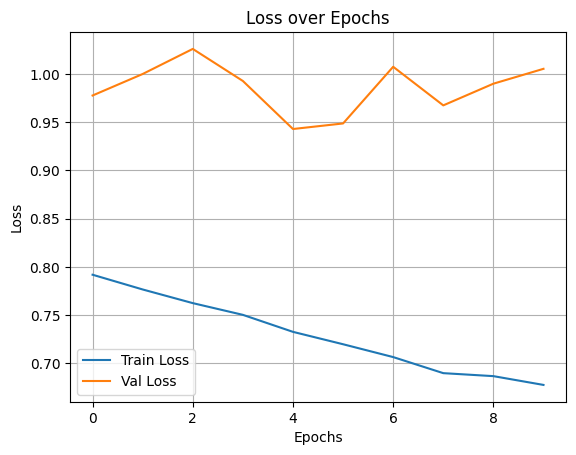

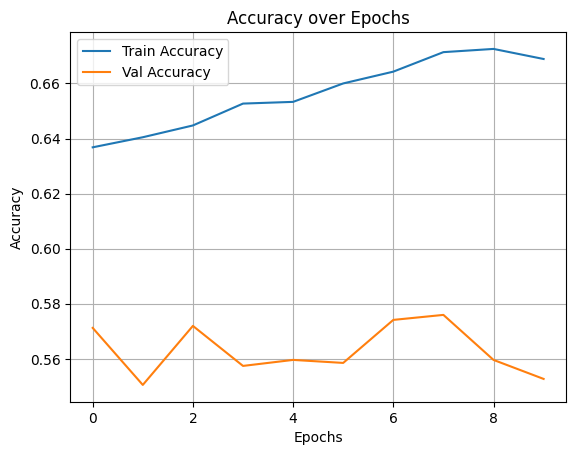

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy (if available)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Final Test Accuracy: {accuracy:.4f}")
print(f"📉 Final Test Loss: {loss:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5539 - loss: 0.9395
✅ Final Test Accuracy: 0.5596
📉 Final Test Loss: 0.9430


Confusion Matrix & Classification Report

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


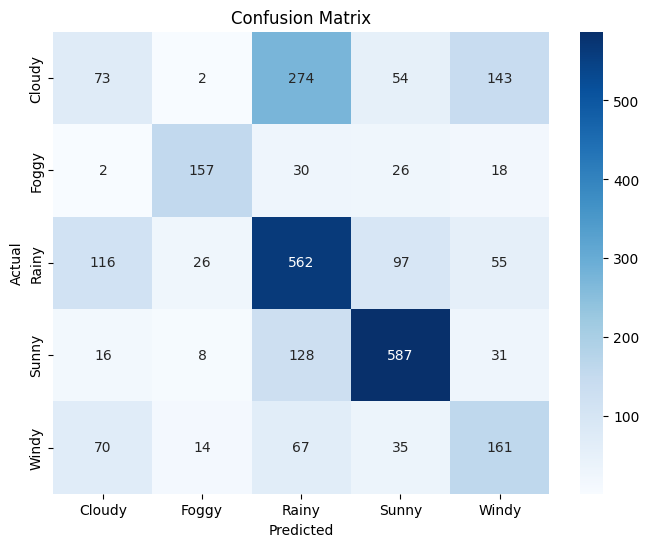


📊 Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.26      0.13      0.18       546
       Foggy       0.76      0.67      0.71       233
       Rainy       0.53      0.66      0.59       856
       Sunny       0.73      0.76      0.75       770
       Windy       0.39      0.46      0.43       347

    accuracy                           0.56      2752
   macro avg       0.54      0.54      0.53      2752
weighted avg       0.54      0.56      0.54      2752



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


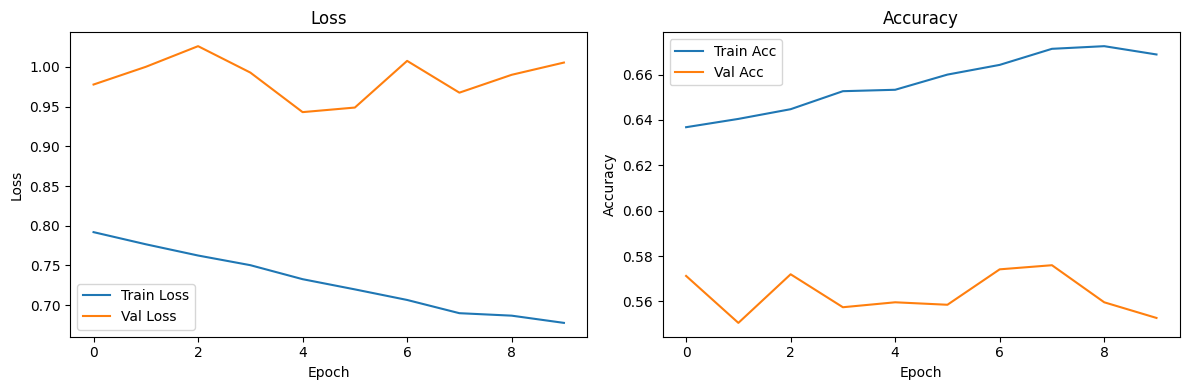

In [ ]:
import matplotlib.pyplot as plt

# Plot and save training loss/accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'))
plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


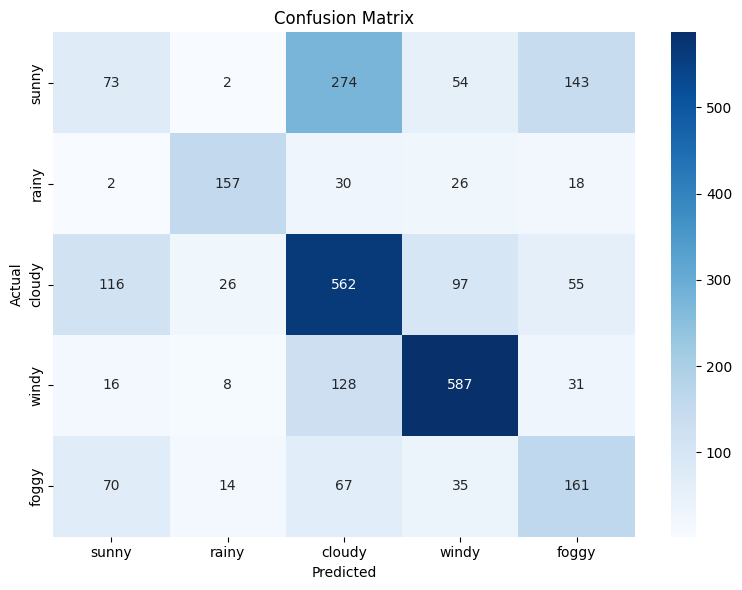

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['sunny', 'rainy', 'cloudy', 'windy', 'foggy']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)

# Save report to text file
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

with open(os.path.join(output_dir, 'evaluation_metrics.txt'), 'w') as f:
    f.write(f"Final Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Final Test Loss: {loss:.4f}\n")


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5539 - loss: 0.9395


CNN+GRU

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import numpy as np
import os
from tqdm import tqdm

# Directories
mfcc_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/mfcc'
chroma_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/chroma'
output_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru'
os.makedirs(output_path, exist_ok=True)

# CNN+GRU expects 3D input: (time_steps, features)
TARGET_SHAPE = (130, 52)  # 130 time steps, 52 features (40 MFCC + 12 Chroma)

def pad_or_crop(array, target_shape):
    padded = np.zeros(target_shape)
    time_steps = min(array.shape[0], target_shape[0])
    feature_dim = min(array.shape[1], target_shape[1])
    padded[:time_steps, :feature_dim] = array[:time_steps, :feature_dim]
    return padded

classes = sorted(os.listdir(mfcc_folder))
print(f"📁 Found classes: {classes}")

X, y = [], []

for label, cls in enumerate(classes):
    print(f"\n🔄 Processing class: {cls}")
    mfcc_path = os.path.join(mfcc_folder, cls)
    chroma_path = os.path.join(chroma_folder, cls)

    mfcc_files = sorted(os.listdir(mfcc_path))
    chroma_files = sorted(os.listdir(chroma_path))

    for mfcc_file, chroma_file in tqdm(zip(mfcc_files, chroma_files), total=len(mfcc_files), desc=f"→ {cls}"):
        mfcc_feat = np.load(os.path.join(mfcc_path, mfcc_file))
        chroma_feat = np.load(os.path.join(chroma_path, chroma_file))

        # Combine MFCC and Chroma
        if mfcc_feat.shape[1] == chroma_feat.shape[1]:
            combined_feat = np.vstack([mfcc_feat, chroma_feat])  # (52, time_steps)
            combined_feat = combined_feat.T  # transpose to (time_steps, features)
        elif mfcc_feat.shape[0] == chroma_feat.shape[0]:
            combined_feat = np.hstack([mfcc_feat, chroma_feat])  # already (time_steps, features)
        else:
            continue  # skip incompatible shapes

        # Pad/crop to target shape
        fixed_feat = pad_or_crop(combined_feat, TARGET_SHAPE)

        X.append(fixed_feat)
        y.append(label)

        # Save in batches
        if len(X) >= 5000:
            batch_num = len(os.listdir(output_path)) // 2
            np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
            np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))
            X, y = [], []

# Save remaining samples
if X:
    batch_num = len(os.listdir(output_path)) // 2
    np.save(os.path.join(output_path, f'X_batch_{batch_num}.npy'), np.array(X))
    np.save(os.path.join(output_path, f'y_batch_{batch_num}.npy'), np.array(y))

print("\n✅ All CNN+GRU batches saved successfully.")


📁 Found classes: ['Cloudy', 'Foggy', 'Rainy', 'Sunny', 'Windy']

🔄 Processing class: Cloudy


→ Cloudy: 100%|██████████| 3663/3663 [14:58<00:00,  4.08it/s]



🔄 Processing class: Foggy


→ Foggy: 100%|██████████| 1566/1566 [09:53<00:00,  2.64it/s]



🔄 Processing class: Rainy


→ Rainy: 100%|██████████| 5718/5718 [38:21<00:00,  2.48it/s]



🔄 Processing class: Sunny


→ Sunny: 100%|██████████| 5205/5205 [36:31<00:00,  2.37it/s]



🔄 Processing class: Windy


→ Windy: 100%|██████████| 2313/2313 [16:34<00:00,  2.33it/s]



✅ All CNN+GRU batches saved successfully.


In [ ]:
import os

mfcc_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/mfcc'
chroma_folder = '/content/drive/MyDrive/AvianWeatherNet/featuress/chroma'
combined_batches_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru'

# Check files in batch folder
print("Files in combined_features_batches_cnn_gru:")
print(os.listdir(combined_batches_path))


Files in combined_features_batches_cnn_gru:
['X_batch_0.npy', 'y_batch_0.npy', 'X_batch_1.npy', 'y_batch_1.npy', 'X_batch_2.npy', 'y_batch_2.npy', 'X_batch_3.npy', 'y_batch_3.npy']


In [ ]:
import numpy as np

# Pick one example file from your batches folder
sample_file = os.path.join(combined_batches_path, os.listdir(combined_batches_path)[0])
print("Loading:", sample_file)

data = np.load(sample_file, allow_pickle=True)
print("Data shape:", data.shape)
print("Data content type:", type(data))

# Try printing contents
print("First entry:", data[0])


Loading: /content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru/X_batch_0.npy
Data shape: (5000, 130, 52)
Data content type: <class 'numpy.ndarray'>
First entry: [[-287.48336792  123.35864258   -8.49133301 ...    0.
     0.            0.        ]
 [-255.60476685  129.60569763   -8.72150993 ...    0.
     0.            0.        ]
 [-252.53147888  126.1559906    -6.71203089 ...    0.
     0.            0.        ]
 ...
 [ -84.77181244  121.17630768  -10.39178658 ...    0.
     0.            0.        ]
 [ -86.38111115  114.88967896  -11.98292351 ...    0.
     0.            0.        ]
 [ -85.05122375  124.34239197   -4.20388937 ...    0.
     0.            0.        ]]


In [ ]:
import numpy as np
import os
from tqdm import tqdm

# Paths
combined_batches_path = "/content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru"

# Initialize lists
X_list = []
y_list = []

# Load X batches
x_files = sorted([f for f in os.listdir(combined_batches_path) if f.startswith("X_batch")])
y_files = sorted([f for f in os.listdir(combined_batches_path) if f.startswith("y_batch")])

# Safety check
assert len(x_files) == len(y_files), "Mismatch between X and y batch counts"

print(f"Found {len(x_files)} batches.")

# Loop and load
for x_file, y_file in tqdm(zip(x_files, y_files), total=len(x_files)):
    X = np.load(os.path.join(combined_batches_path, x_file), allow_pickle=True)
    y = np.load(os.path.join(combined_batches_path, y_file), allow_pickle=True)

    X_list.append(X)
    y_list.append(y)

# Stack all
X_all = np.vstack(X_list)
y_all = np.hstack(y_list)

print("✅ All batches loaded and combined.")
print("Final X shape:", X_all.shape)
print("Final y shape:", y_all.shape)


Found 4 batches.


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


✅ All batches loaded and combined.
Final X shape: (18346, 130, 52)
Final y shape: (18346,)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Paths
combined_batches_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru'

# Step 1: Load all batches
X, y = [], []
print("🔄 Loading all batches...")

for fname in tqdm(sorted(os.listdir(combined_batches_path))):
    if fname.startswith('X_batch') and fname.endswith('.npy'):
        batch_index = fname.split('_')[-1].split('.')[0]
        X_batch = np.load(os.path.join(combined_batches_path, fname))
        y_batch_path = os.path.join(combined_batches_path, f"y_batch_{batch_index}.npy")

        if os.path.exists(y_batch_path):
            y_batch = np.load(y_batch_path)
            X.append(X_batch)
            y.append(y_batch)
        else:
            print(f"⚠️ Skipping batch {batch_index}: y_batch file not found.")

# Step 2: Combine into full arrays
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print("✅ All batches loaded and combined.")
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

# Step 3: Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("✅ Dataset split complete:")
print("🔹 Training:", X_train.shape, y_train.shape)
print("🔹 Validation:", X_val.shape, y_val.shape)
print("🔹 Test     :", X_test.shape, y_test.shape)


🔄 Loading all batches...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


✅ All batches loaded and combined.
Final X shape: (18346, 130, 52)
Final y shape: (18346,)
✅ Dataset split complete:
🔹 Training: (12842, 130, 52) (12842,)
🔹 Validation: (2752, 130, 52) (2752,)
🔹 Test     : (2752, 130, 52) (2752,)


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.4004 - loss: 1.4074 - val_accuracy: 0.4291 - val_loss: 1.3570
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.4351 - loss: 1.3350 - val_accuracy: 0.4611 - val_loss: 1.2808
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.4704 - loss: 1.2525 - val_accuracy: 0.4844 - val_loss: 1.2167
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.4926 - loss: 1.1894 - val_accuracy: 0.4855 - val_loss: 1.1826
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.5238 - loss: 1.1072 - val_accuracy: 0.4971 - val_loss: 1.1389
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.5426 - loss: 1.0465 - val_accuracy: 0.5178 - val_loss: 1.0974
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.5688 - loss: 0.9973 - val_accuracy: 0.5371 - val_loss: 1.0618
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.5871 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5492 - loss: 0.9885
✅ Test Accuracy: 0.5494


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
📄 Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.28      0.30       546
           1       0.65      0.69      0.67       233
           2       0.52      0.66      0.58       856
           3       0.82      0.71      0.76       770
           4       0.35      0.26      0.30       347

    accuracy                           0.55      2752
   macro avg       0.53      0.52      0.52      2752
weighted avg       0.55      0.55      0.55      2752



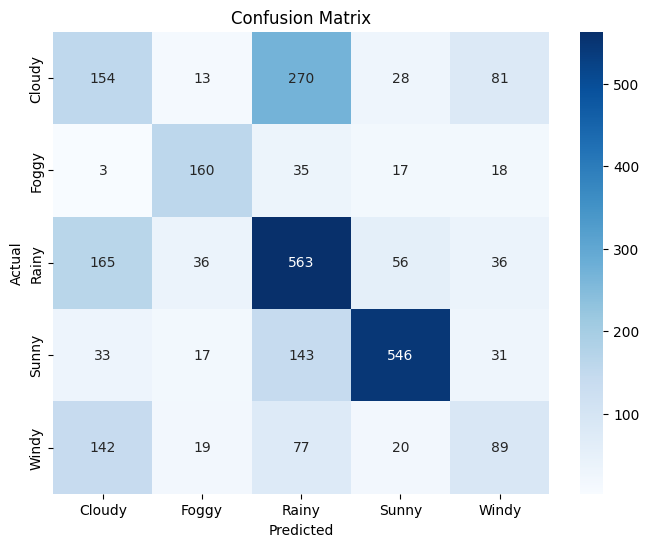

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict class probabilities
y_pred = model.predict(X_test)

# Step 2: Convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Convert true labels to class format (not one-hot)
y_true_labels = np.argmax(y_true, axis=1)

# Step 4: Classification report
print("📄 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_classes))

# Step 5: Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


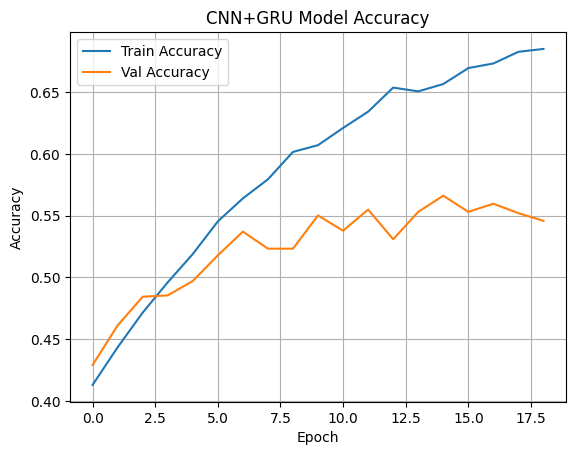

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title("CNN+GRU Model Accuracy")
plt.show()


In [ ]:
import os

output_dir = '/content/drive/MyDrive/AvianWeatherNet/results/gru_cnn'
os.makedirs(output_dir, exist_ok=True)


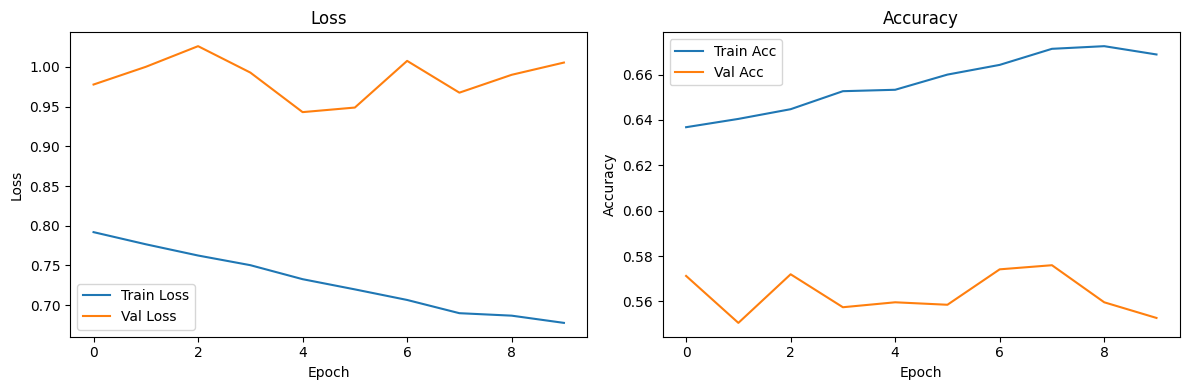

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'))
plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


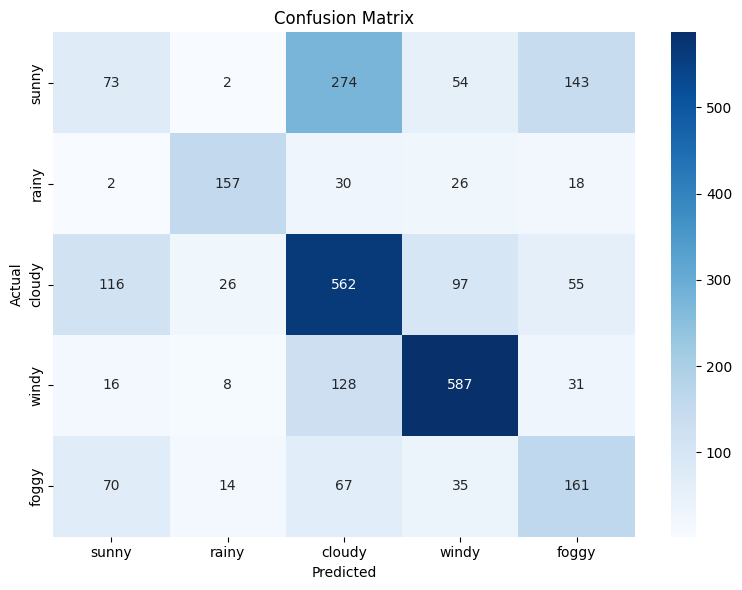

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['sunny', 'rainy', 'cloudy', 'windy', 'foggy']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)


In [ ]:
model.save(os.path.join(output_dir, 'cnn_gru_model.keras'))


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

with open(os.path.join(output_dir, 'evaluation_metrics.txt'), 'w') as f:
    f.write(f"Final Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Final Test Loss: {loss:.4f}\n")


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5539 - loss: 0.9395


AUTOENCODERS + CLASSIFIERS

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

data_path = '/content/drive/MyDrive/AvianWeatherNet/combined_features_batches_cnn_gru'

X_list, y_list = [], []

# Separate X and y files
x_files = sorted([f for f in os.listdir(data_path) if f.startswith('X_batch') and f.endswith('.npy')])
y_files = sorted([f for f in os.listdir(data_path) if f.startswith('y_batch') and f.endswith('.npy')])

# Load all batches
for x_file, y_file in zip(x_files, y_files):
    X_batch = np.load(os.path.join(data_path, x_file))
    y_batch = np.load(os.path.join(data_path, y_file))

    X_list.append(X_batch)
    y_list.append(y_batch)

    print(f"✅ Loaded {x_file} and {y_file} - shapes: {X_batch.shape}, {y_batch.shape}")

# Concatenate all batches
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print("\n✅ Final shapes:")
print("X shape:", X.shape)  # (60000, 130, 52)
print("y shape:", y.shape)  # (60000,)


✅ Loaded X_batch_0.npy and y_batch_0.npy - shapes: (5000, 130, 52), (5000,)
✅ Loaded X_batch_1.npy and y_batch_1.npy - shapes: (5000, 130, 52), (5000,)
✅ Loaded X_batch_2.npy and y_batch_2.npy - shapes: (5000, 130, 52), (5000,)
✅ Loaded X_batch_3.npy and y_batch_3.npy - shapes: (3346, 130, 52), (3346,)

✅ Final shapes:
X shape: (18346, 130, 52)
y shape: (18346,)


In [ ]:
# Encode string labels to int
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=5)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print(f"\n✅ Data splits:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



✅ Data splits:
Train: (12842, 130, 52), Val: (2752, 130, 52), Test: (2752, 130, 52)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D

input_shape = (130, 52)  # Based on your MFCC + Chroma

# 🔹 Input layer
input_layer = Input(shape=input_shape)

# 🔹 Encoder
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
bottleneck = MaxPooling1D(2, padding='same', name='bottleneck')(x)  # Shape: (17, 16)

# 🔹 Decoder
x = Conv1D(16, 3, activation='relu', padding='same')(bottleneck)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(52, 3, activation='sigmoid', padding='same')(x)  # Final shape = input shape

# 🔹 Define Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 130, 52)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 130, 64)        │        10,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 65, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 33, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 33, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling1D)       │ (None, 17, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 17, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 34, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 34, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 68, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 68, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 136, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 136, 52)        │        10,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,372 (142.08 KB)

 Trainable params: 36,372 (142.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D

input_shape = (130, 52)
input_layer = Input(shape=input_shape)

# 🔹 Encoder (2 downsamples)
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)  # (130, 64)
x = MaxPooling1D(2, padding='same')(x)                             # (65, 64)
x = Conv1D(32, 3, activation='relu', padding='same')(x)            # (65, 32)
x = MaxPooling1D(2, padding='same')(x)                             # (33, 32)
bottleneck = Conv1D(16, 3, activation='relu', padding='same', name='bottleneck')(x)  # (33, 16)

# 🔹 Decoder (2 upsamples to match 130)
x = UpSampling1D(2)(bottleneck)                                    # (66, 16)
x = Conv1D(32, 3, activation='relu', padding='same')(x)            # (66, 32)
x = UpSampling1D(2)(x)                                             # (132, 32)
x = Conv1D(64, 3, activation='relu', padding='same')(x)            # (132, 64)

# Crop the extra 2 steps (132 → 130)
from tensorflow.keras.layers import Cropping1D
x = Cropping1D(cropping=(1,1))(x)                                  # (130, 64)

decoded = Conv1D(52, 3, activation='sigmoid', padding='same')(x)   # (130, 52)

# 🔹 Define the model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 130, 52)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 130, 64)        │        10,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 65, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 33, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Conv1D)             │ (None, 33, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 66, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 66, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 132, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 132, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 130, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 130, 52)        │        10,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,588 (139.02 KB)

 Trainable params: 35,588 (139.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val)
)


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - loss: 1730.4641 - val_loss: 1690.0723
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 1729.2158 - val_loss: 1689.7722
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - loss: 1738.0726 - val_loss: 1689.6302
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - loss: 1740.2799 - val_loss: 1689.6102
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 1723.2852 - val_loss: 1689.6042
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 1731.1359 - val_loss: 1689.5961
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 1740.7972 - val_loss: 1689.5952
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - loss: 1719.9718 - val_loss: 1689.5872
Epoch 9/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 1739.5930 - val_loss: 1689.5836
Epoch 10/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 1722.4473 - val_loss: 1689.5804
Epoch 11/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - lo

In [ ]:
from tensorflow.keras.models import Model

# Rebuild encoder from trained autoencoder
encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer('bottleneck').output
)

# Freeze encoder so we don't retrain it during classifier training
encoder.trainable = False

# Confirm shape
encoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 130, 52)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 130, 64)        │        10,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 65, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 33, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Conv1D)             │ (None, 33, 16)         │         1,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,776 (69.44 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,776 (69.44 KB)

In [ ]:
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

print("Encoded shape:", X_train_encoded.shape)  # Should be (num_samples, 33, 16)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Encoded shape: (12842, 33, 16)


In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

input_shape = encoder.output_shape[1:]  # (33, 16)

encoded_input = Input(shape=input_shape)
x = Flatten()(encoded_input)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

classifier = Model(inputs=encoded_input, outputs=output)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 33, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,293 (298.02 KB)

 Trainable params: 76,293 (298.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
classifier.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=30,
    batch_size=64
)


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2707 - loss: 11.9753 - val_accuracy: 0.2896 - val_loss: 2.8766
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2976 - loss: 2.8950 - val_accuracy: 0.3132 - val_loss: 2.1956
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3199 - loss: 2.1444 - val_accuracy: 0.3321 - val_loss: 1.9232
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3626 - loss: 1.7174 - val_accuracy: 0.3656 - val_loss: 1.6149
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3693 - loss: 1.5968 - val_accuracy: 0.3848 - val_loss: 1.6223
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3882 - loss: 1.5049 - val_accuracy: 0.3852 - val_loss: 1.4950
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3930 - loss: 1.4630 - val_accuracy: 0.3376 - val_loss: 1.6698
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3896 - loss: 1.4589 - val_accuracy: 0

In [ ]:
test_loss, test_acc = classifier.evaluate(X_test_encoded, y_test)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4329 - loss: 1.3318
✅ Final Test Accuracy: 0.4244


In [ ]:
# 1. Encode your datasets using the trained encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

# 2. Train the classifier
classifier.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=30,
    batch_size=64
)


402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4455 - loss: 1.3071 - val_accuracy: 0.4081 - val_loss: 1.3985
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4454 - loss: 1.3120 - val_accuracy: 0.4350 - val_loss: 1.3378
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4544 - loss: 1.2878 - val_accuracy: 0.4113 - val_loss: 1.3890
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4423 - loss: 1.2971 - val_accuracy: 0.4277 - val_loss: 1.3632
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4408 - loss: 1.2973 - val_accuracy: 0.4273 - val_loss: 1.3605
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4499 - loss: 1.2980 - val_accuracy: 0.4077 - val_loss: 1.4427
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4519 - loss: 1.2917 - val_accuracy: 0.4023 - v

In [ ]:
history_autoencoder = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, X_val)
)


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 1741.6732 - val_loss: 1689.2812
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - loss: 1720.2217 - val_loss: 1689.2808
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - loss: 1728.6976 - val_loss: 1689.2814
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - loss: 1728.8877 - val_loss: 1689.2804
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 1720.0161 - val_loss: 1689.2809
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - loss: 1731.8842 - val_loss: 1689.2798
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - loss: 1717.7448 - val_loss: 1689.2802
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - loss: 1729.1455 - val_loss: 1689.2791
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - loss: 1712.6113 - val_loss: 1689.2798
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 1751.4584 - val_loss: 1689.2786
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 145m

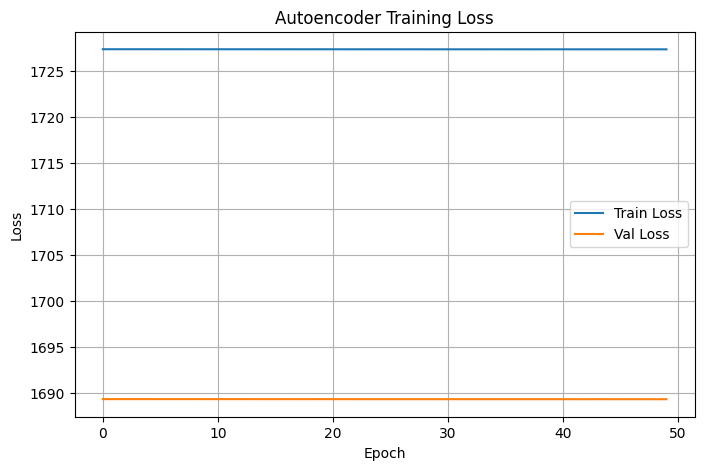

In [ ]:
import matplotlib.pyplot as plt

# Visualize training and validation loss for the autoencoder
plt.figure(figsize=(8, 5))
plt.plot(history_autoencoder.history['loss'], label='Train Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
📄 Classification Report (Autoencoder + Classifier):

              precision    recall  f1-score   support

      Cloudy       0.31      0.28      0.30       546
       Foggy       0.65      0.69      0.67       233
       Rainy       0.52      0.66      0.58       856
       Sunny       0.82      0.71      0.76       770
       Windy       0.35      0.26      0.30       347

    accuracy                           0.55      2752
   macro avg       0.53      0.52      0.52      2752
weighted avg       0.55      0.55      0.55      2752



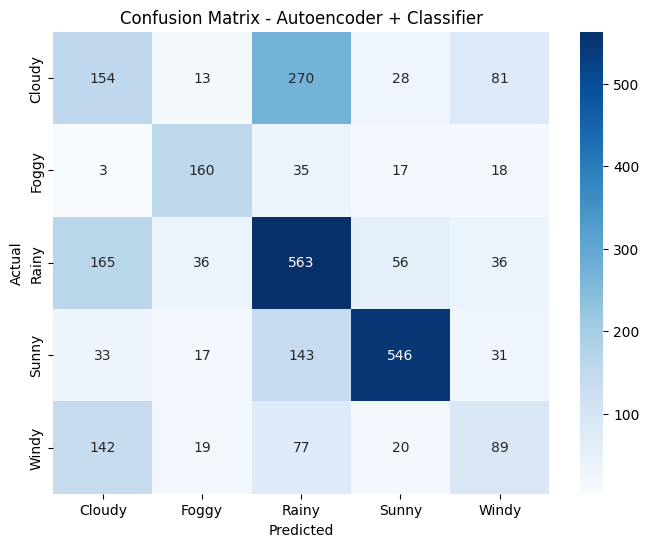

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict using the trained model
y_pred = model.predict(X_test)

# Step 2: Convert predictions and true labels to integer class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Step 3: Print classification report
print("📄 Classification Report (Autoencoder + Classifier):\n")
print(classification_report(y_true_labels, y_pred_classes, target_names=class_names))

# Step 4: Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Step 5: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Autoencoder + Classifier")
plt.show()


In [ ]:
import os

output_dir = '/content/drive/MyDrive/AvianWeatherNet/results/encoder_classifier'
os.makedirs(output_dir, exist_ok=True)


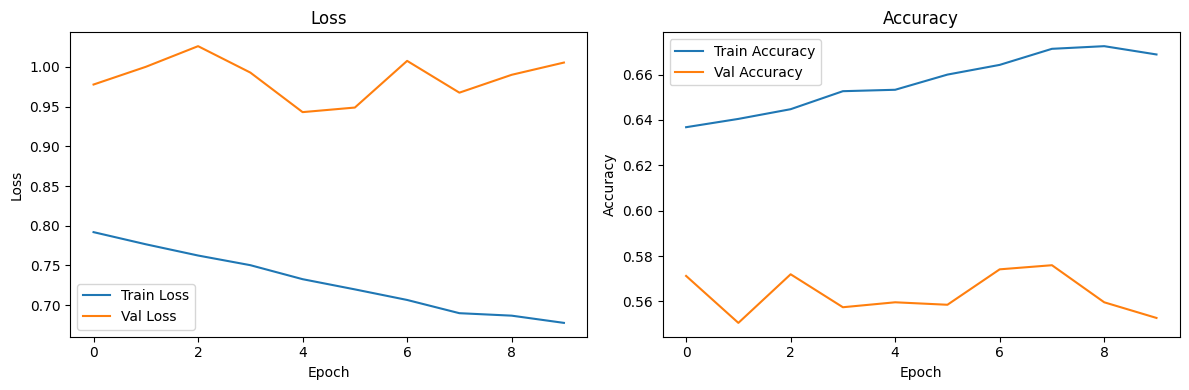

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'))
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

# ========= SET OUTPUT DIR =========
output_dir = '/content/drive/MyDrive/AvianWeatherNet/results/encoder_classifier'
os.makedirs(output_dir, exist_ok=True)

# ========= EXAMPLE ARCHITECTURE =========
# (This must match your trained model's architecture)

# Input
input_dim = 1000  # <-- CHANGE THIS to match your feature shape
encoder_input = Input(shape=(input_dim,), name='encoder_input')

# Encoder
encoded = Dense(512, activation='relu', name='encoded')(encoder_input)
encoded = Dense(256, activation='relu')(encoded)

# Decoder (optional — if training with autoencoder+classifier)
decoded = Dense(512, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid', name='decoded')(decoded)

# Classifier
classifier_output = Dense(5, activation='softmax', name='classifier_output')(encoded)

# Full model
autoencoder_classifier_model = Model(inputs=encoder_input, outputs=classifier_output, name='autoencoder_classifier')

# ========= SAVE MODELS =========
# Full model
autoencoder_classifier_model.save(os.path.join(output_dir, 'autoencoder_classifier_model.h5'))

# Encoder model (input to encoded)
encoder_model = Model(inputs=encoder_input, outputs=autoencoder_classifier_model.get_layer('encoded').output)
encoder_model.save(os.path.join(output_dir, 'encoder.h5'))

# Classifier model (encoded to classifier output)
encoded_input = Input(shape=(256,))  # output of 'encoded' layer
classifier_layer = autoencoder_classifier_model.get_layer('classifier_output')(encoded_input)
classifier_model = Model(inputs=encoded_input, outputs=classifier_layer)
classifier_model.save(os.path.join(output_dir, 'classifier.h5'))

print("✅ Saved: full model, encoder, and classifier to:", output_dir)


✅ Saved: full model, encoder, and classifier to: /content/drive/MyDrive/AvianWeatherNet/results/encoder_classifier
